In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler #scaling de los datos entre 0 y 1
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [3]:
#cargo primero los datos
file_dir = 'Datos/RiesgoBariloche'
data = pd.read_csv(file_dir,sep=",",quotechar='"',na_values=[''])
data = data["incidenciaAcum14d"]
df = pd.DataFrame(data)
df = df.to_numpy()
df1 = np.copy(df) #el original
df = df[:-20] #saco los ultimos 20 dias (ult 10 para probar + ult 10 retrasados)
df1 = df1[:-10] #saco los ultimos 10 dias retrasados

In [4]:
#normalizacion
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(df.reshape(-1,1))
df += np.random.normal(0,0.01,df.shape)
df = df.reshape(-1,1)
#split en train y test
training_size=int(len(df)*0.8)
test_size=len(df)-training_size
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1] #train y test data
lag = 3 #creo que este es el que deducen en el paper
#creo los que vienen para la red
x_train, y_train = create_dataset(train_data, lag)
x_test, y_test = create_dataset(test_data, lag)

In [5]:
# reshape en (samples, time steps, features) para lstm como en pract7
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)

In [17]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=100,activation='relu',return_sequences=True,input_shape=(lag,1),recurrent_dropout=0.2))
model.add(keras.layers.LSTM(units=100,activation='relu',recurrent_dropout=0.2))
#model.add(keras.layers.Dense(units=64,activation='relu'))
#model.add(keras.layers.Dense(units=32,activation='relu'))
model.add(keras.layers.Dense(units=1))
optimizer = keras.optimizers.Adam(5e-2)
model.compile(optimizer,loss=keras.losses.MSE,metrics=['mse']) #metrics=['mean_absolute_percentage_error']
model.summary()
history = model.fit(x_train, y_train,epochs=100,validation_data=(x_test,y_test),batch_size=8,verbose=2) 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 3, 100)            40800     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
Train on 231 samples, validate on 55 samples
Epoch 1/100
 - 1s - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0161 - val_mse: 0.0161
Epoch 2/100
 - 0s - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 3/100
 - 0s - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0147 - val_mse: 0.0147
Epoch 4/100
 - 0s - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0908 - val_mse: 0.09

Epoch 83/100
 - 0s - loss: 6.6739e-04 - mse: 6.6739e-04 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 84/100
 - 0s - loss: 4.2876e-04 - mse: 4.2876e-04 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 85/100
 - 0s - loss: 5.5938e-04 - mse: 5.5938e-04 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 86/100
 - 0s - loss: 6.2612e-04 - mse: 6.2612e-04 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 87/100
 - 0s - loss: 5.9339e-04 - mse: 5.9339e-04 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 88/100
 - 0s - loss: 3.9680e-04 - mse: 3.9680e-04 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 89/100
 - 0s - loss: 3.6512e-04 - mse: 3.6512e-04 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 90/100
 - 0s - loss: 4.4291e-04 - mse: 4.4291e-04 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 91/100
 - 0s - loss: 6.9145e-04 - mse: 6.9145e-04 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 92/100
 - 0s - loss: 6.2324e-04 - mse: 6.2324e-04 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 93/100
 - 0s - loss: 2.2739e-04 - mse: 2.2739e-04 - val_loss: 0.

In [18]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

In [19]:
print('train mse squared:',mean_squared_error(y_train,train_predict))
print('test mse squared:',mean_squared_error(y_test,test_predict)) 

train mse squared: 0.0005392579048776044
test mse squared: 0.003966673601829041


In [20]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

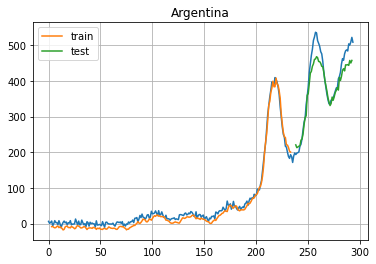

In [21]:
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(train_predict)+lag, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(lag*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot,label='train')
plt.plot(testPredictPlot,label='test')
plt.grid()
plt.title('Argentina')
plt.legend()
plt.show()

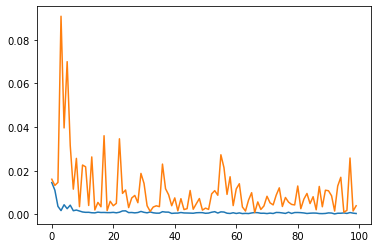

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# aca hacemos el forecast

In [23]:
n = len(test_data)
x_input=test_data[n-lag:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
lst_output=[]
n_steps=lag
i=0

while(i<10): 
    if(len(temp_input)>lag):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, lag, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, lag,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

1 day output [[0.7809942]]
2 day output [[0.74203384]]
3 day output [[0.7202269]]
4 day output [[0.7062001]]
5 day output [[0.6965446]]
6 day output [[0.6900306]]
7 day output [[0.6857637]]
8 day output [[0.6830414]]
9 day output [[0.68134505]]


In [24]:
lst_output = scaler.inverse_transform(lst_output)

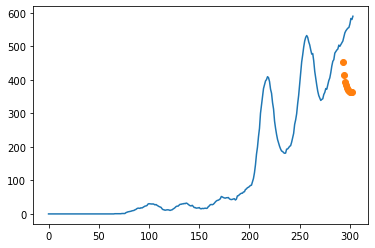

In [25]:
plt.plot(df1)
dias_forecast = np.arange(0,10) + len(df) - 1
plt.plot(dias_forecast,lst_output,'o')
#plt.xlim(290,310)

(290.0, 310.0)

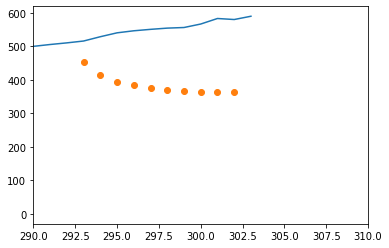

In [26]:
plt.plot(df1)
dias_forecast = np.arange(0,10) + len(df) - 1
plt.plot(dias_forecast,lst_output,'o')
plt.xlim(290,310)

In [27]:
print(df1[-10:]-lst_output)

[[ 75.36114796]
 [124.43528697]
 [151.26663493]
 [167.14142536]
 [178.26697508]
 [185.23519429]
 [199.08232373]
 [217.84125291]
 [216.2357756 ]
 [226.90952609]]
